# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

# Tabla de Contenido

* [1 Inicialización](#1)
* [2 Cargar datos](#2)
* [3 EDA](#3)
* [4 Procedimiento de evaluación](#4)
* [5 Normalización](#5)
* [6 División entrenamiento / prueba](#6)
* [7 Trabajar con modelos](#7)
    * [7.1 7.1 Modelo 0 - Constante](#7.1)
    * [7.2 Modelo 1 - NLTK, TF-IDF y LR](#7.2)
    * [7.3 Modelo 3 - spaCy, TF-IDF y LR](#7.3)
    * [7.4 Modelo 4 - spaCy, TF-IDF y LGBMClassifier](#7.4)
    * [7.5 Modelo 5 - BERT](#7.5)
* [8 Mis reseñas](#8)
    * [8.1 Modelo 2](#8.1)
    * [8.2 Modelo 3](#8.2)
    * [8.3 Modelo 4](#8.3)
    * [8.4 Modelo 9](#8.4)
* [9 Conclusiones](#9)


## Inicialización

In [4]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')


import sklearn.metrics as metrics

from sklearn.dummy import DummyClassifier

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

from lightgbm import LGBMClassifier

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Nota: Se colocaron todas las librerias en este apartado

¡Empecemos!

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [6]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration

tqdm.pandas()

## Cargar datos

In [7]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [8]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [9]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [10]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


**Conclusiones Intermedias:**

1. Podemos observar que las peliculas van dentro del rango de la más antigua es del año 1894, mientras que la mas actualizada es del año 2010.

2. El promedio de calificación de las peliculas es de 6 puntos, siendo el máximo de 9.7 (ninguna obtiene el 10) y la pelicula de menos agrado tiene un 1.4.

3. Cuenta el DataFrame con una gran cantidad de votos, lo cual determina que las peliculas son criticadas u opinadas por una gran poblacion.



## EDA

Veamos el número de películas y reseñas a lo largo de los años.

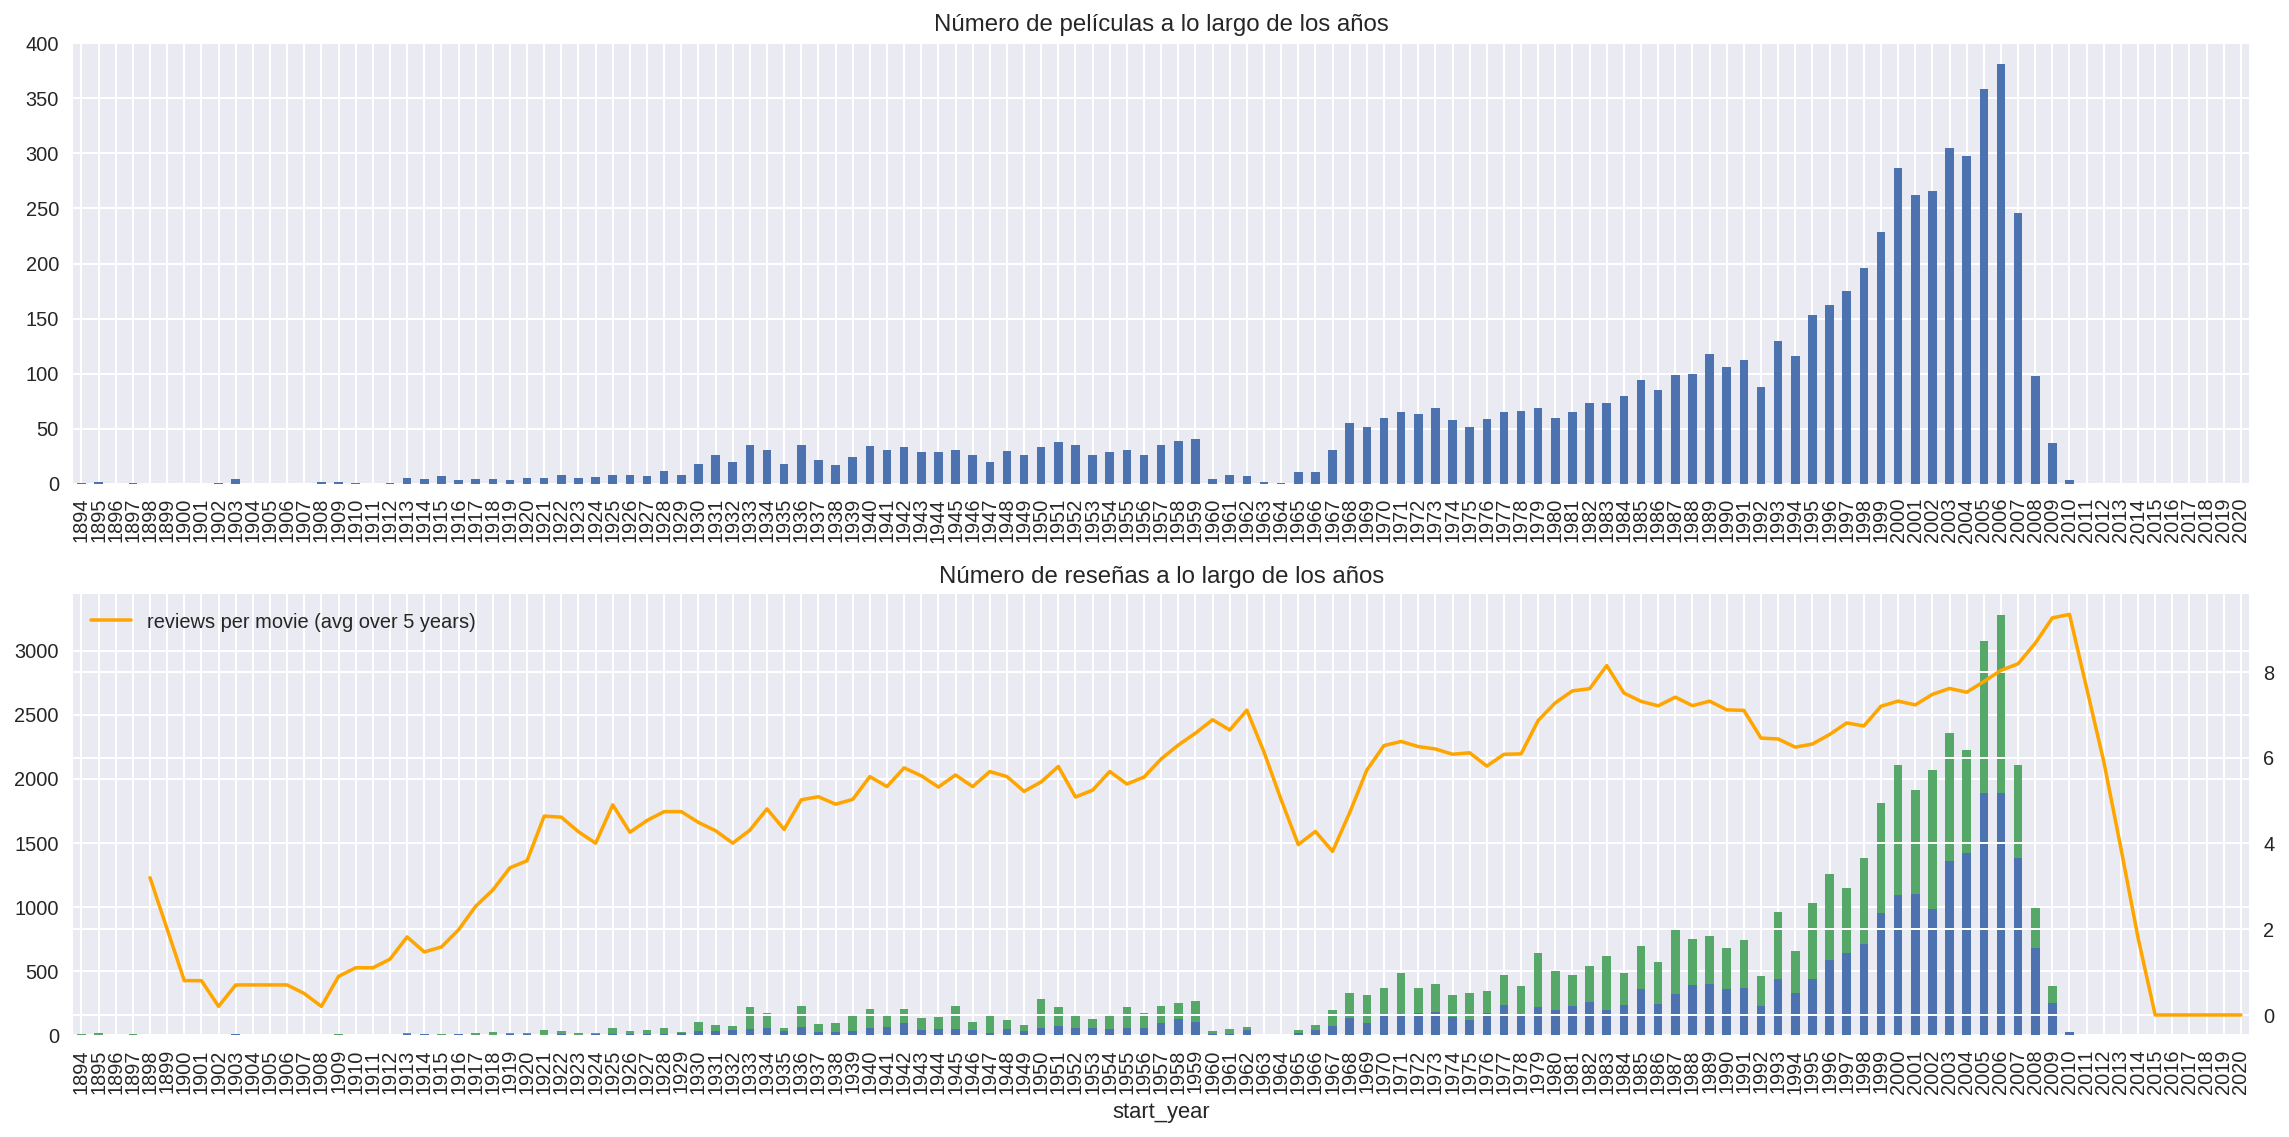

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

**Conclusiones intermedias:**
    
1. Del primer grafico, podemos ver que desde el inicio en 1894, el numero de peliculas va aumentando, tiene una caida en el año de 1960 pero vuelve a subir con mayor enfansis hasta el año 2007.

2. Del segundo grafico, observamos que las reseñas de pelicula tiene una tendencia alcista menos en el periodo de 1960 hasta 1968 hasta que se topa con el año de 2007, cuando baja crucialmente. El año 2006 fue el año con mayores reseñas.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

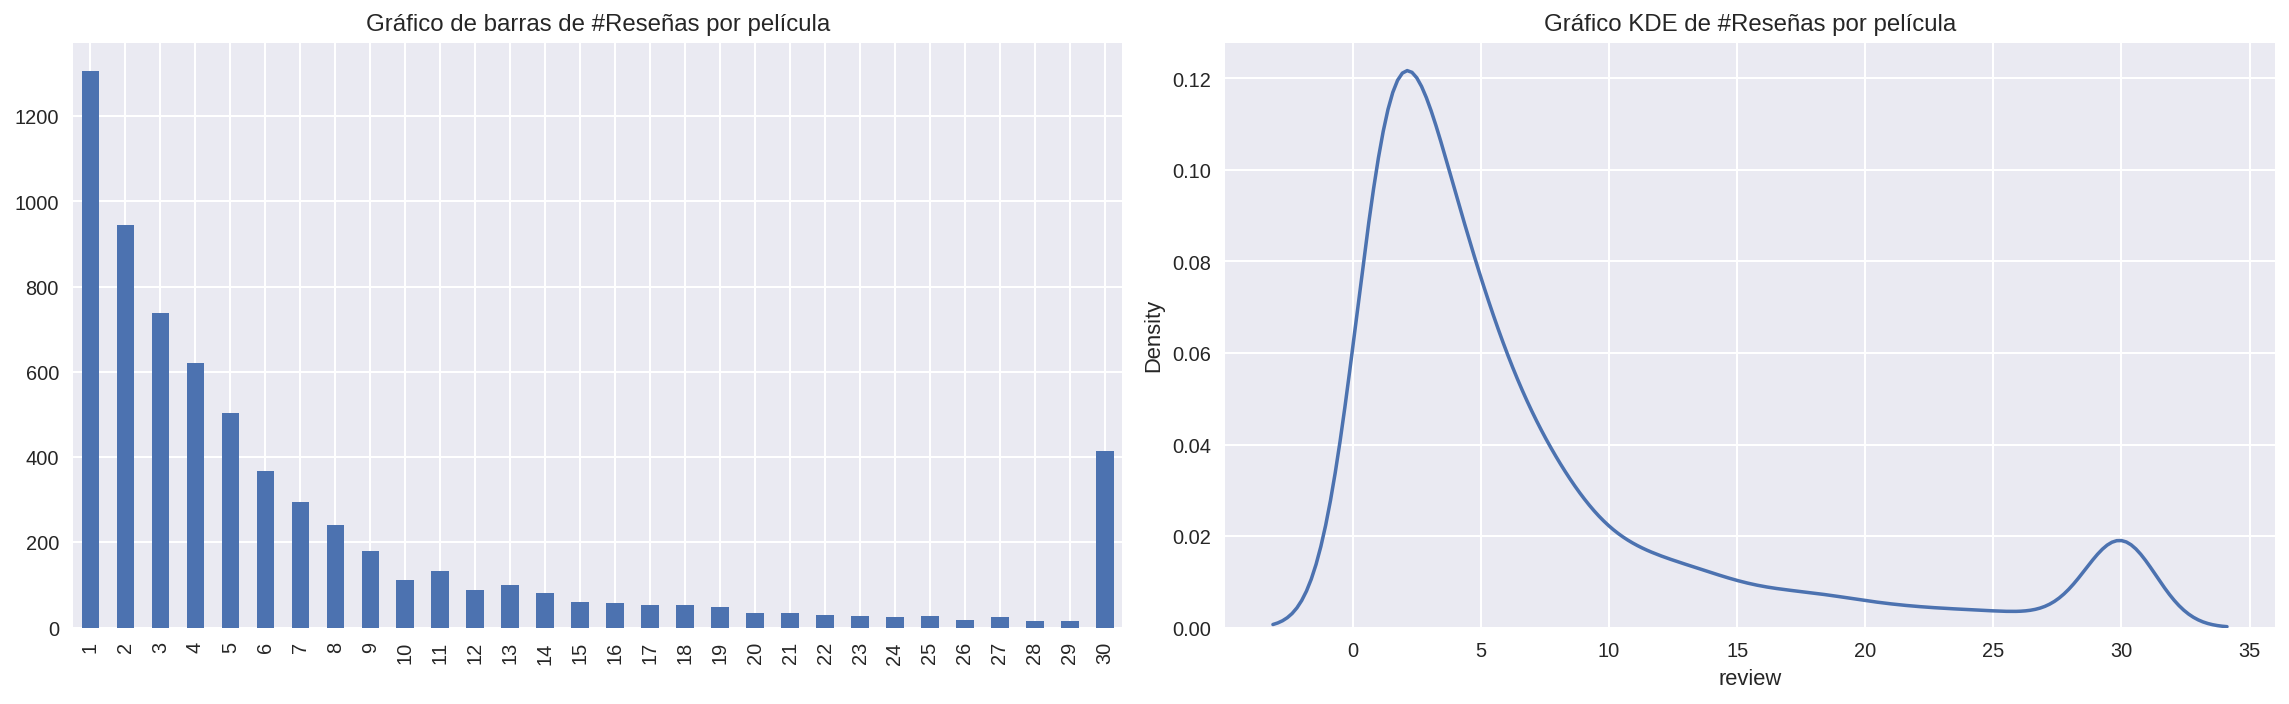

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

**Conclusiones intermedias:**
    
Podemos observar que la gran mayoria de peliculas tienen al menos 1 reseña y el numero va disminuyendo cuando se dan mas reseñas. Hay un valor que es cuando se dieron 30 reseñas llega a un tope de 400 peliculas.   

In [13]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

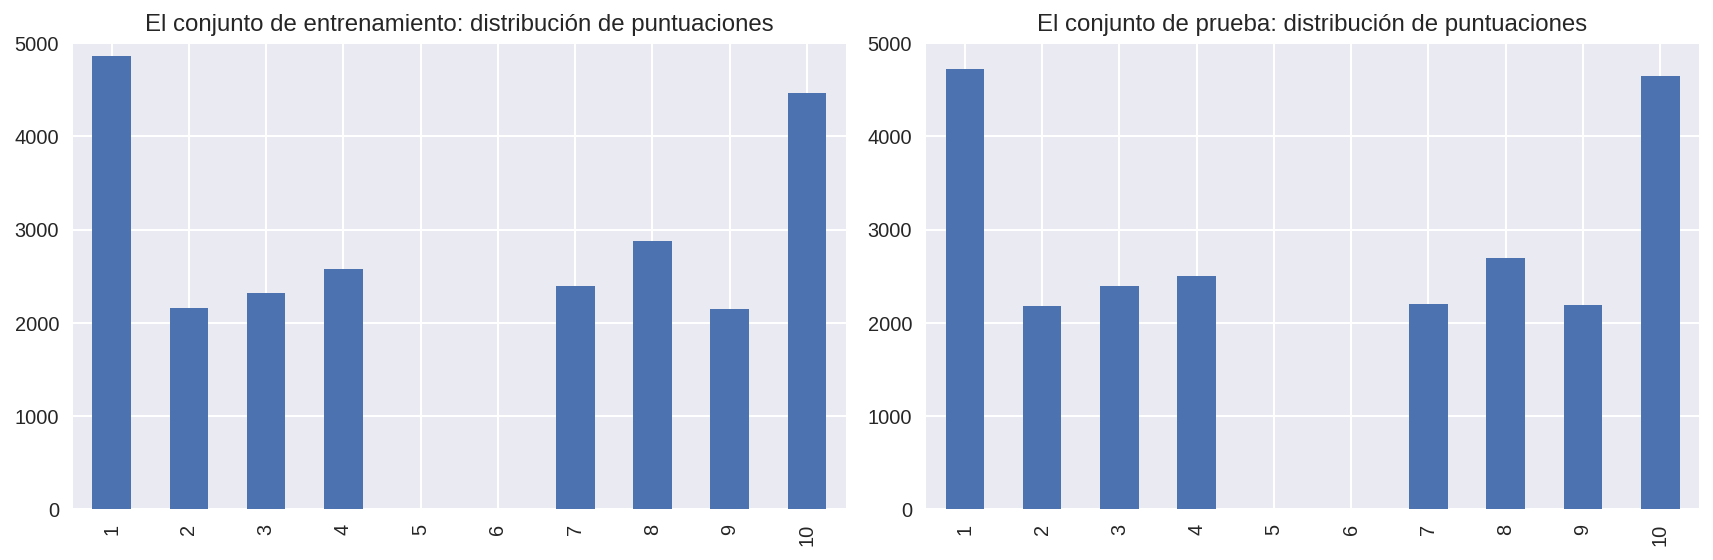

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

**Conclusiones intermedias:**

Podemos observar que para las peliculas con 1 reseña tienen la misma cantidad que las que tienen 10 reseñas, tanto para el conjunto de prueba como el de entrenamiento. Las otras peliculas con reseñas tienen una distribucion similar en ambos conjuntos. 

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

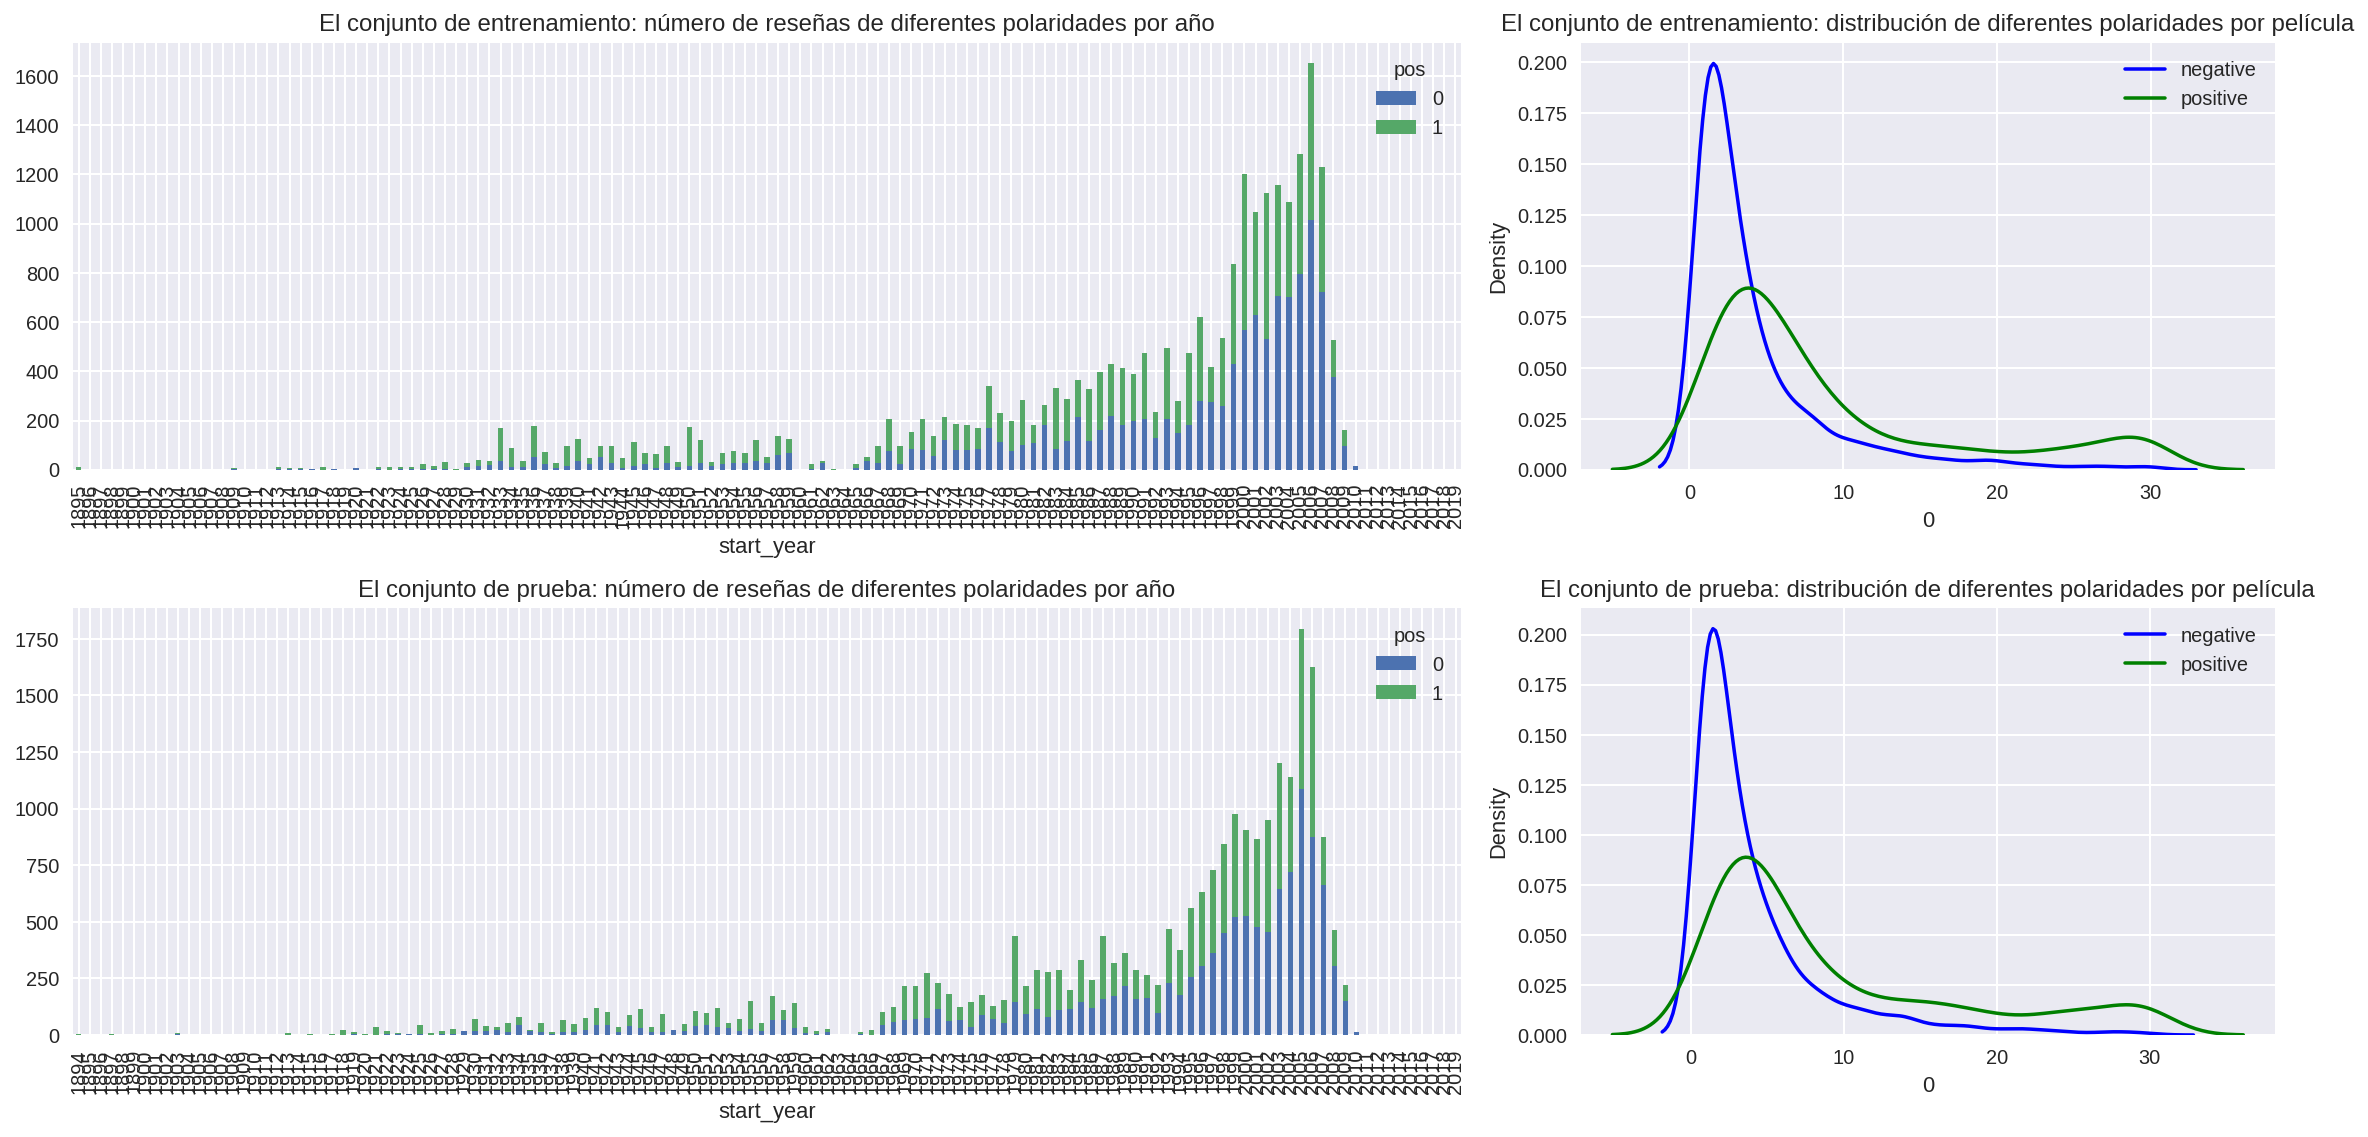

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

**Conclusiones intermedias:**
    
La distribución de las reseñas positivas y negativas en ambos conjuntos es casi igual, a diferencia en el conjunto de prueba que es un poco menos significativa en materia de reseñas.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [16]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [17]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

In [18]:
df_reviews['review'].head()

0    The pakage implies that Warren Beatty and Gold...
1    How the hell did they get this made?! Presenti...
2    There is no real story the film seems more lik...
3    Um .... a serious film about troubled teens in...
4    I'm totally agree with GarryJohal from Singapo...
Name: review, dtype: object

In [19]:
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made   presenti...
2    there is no real story the film seems more lik...
3    um      a serious film about troubled teens in...
4    i m totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [20]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

           train  test
Exactitud   0.50  0.50
F1          0.67  0.67
APS         0.50  0.50
ROC AUC     0.50  0.50


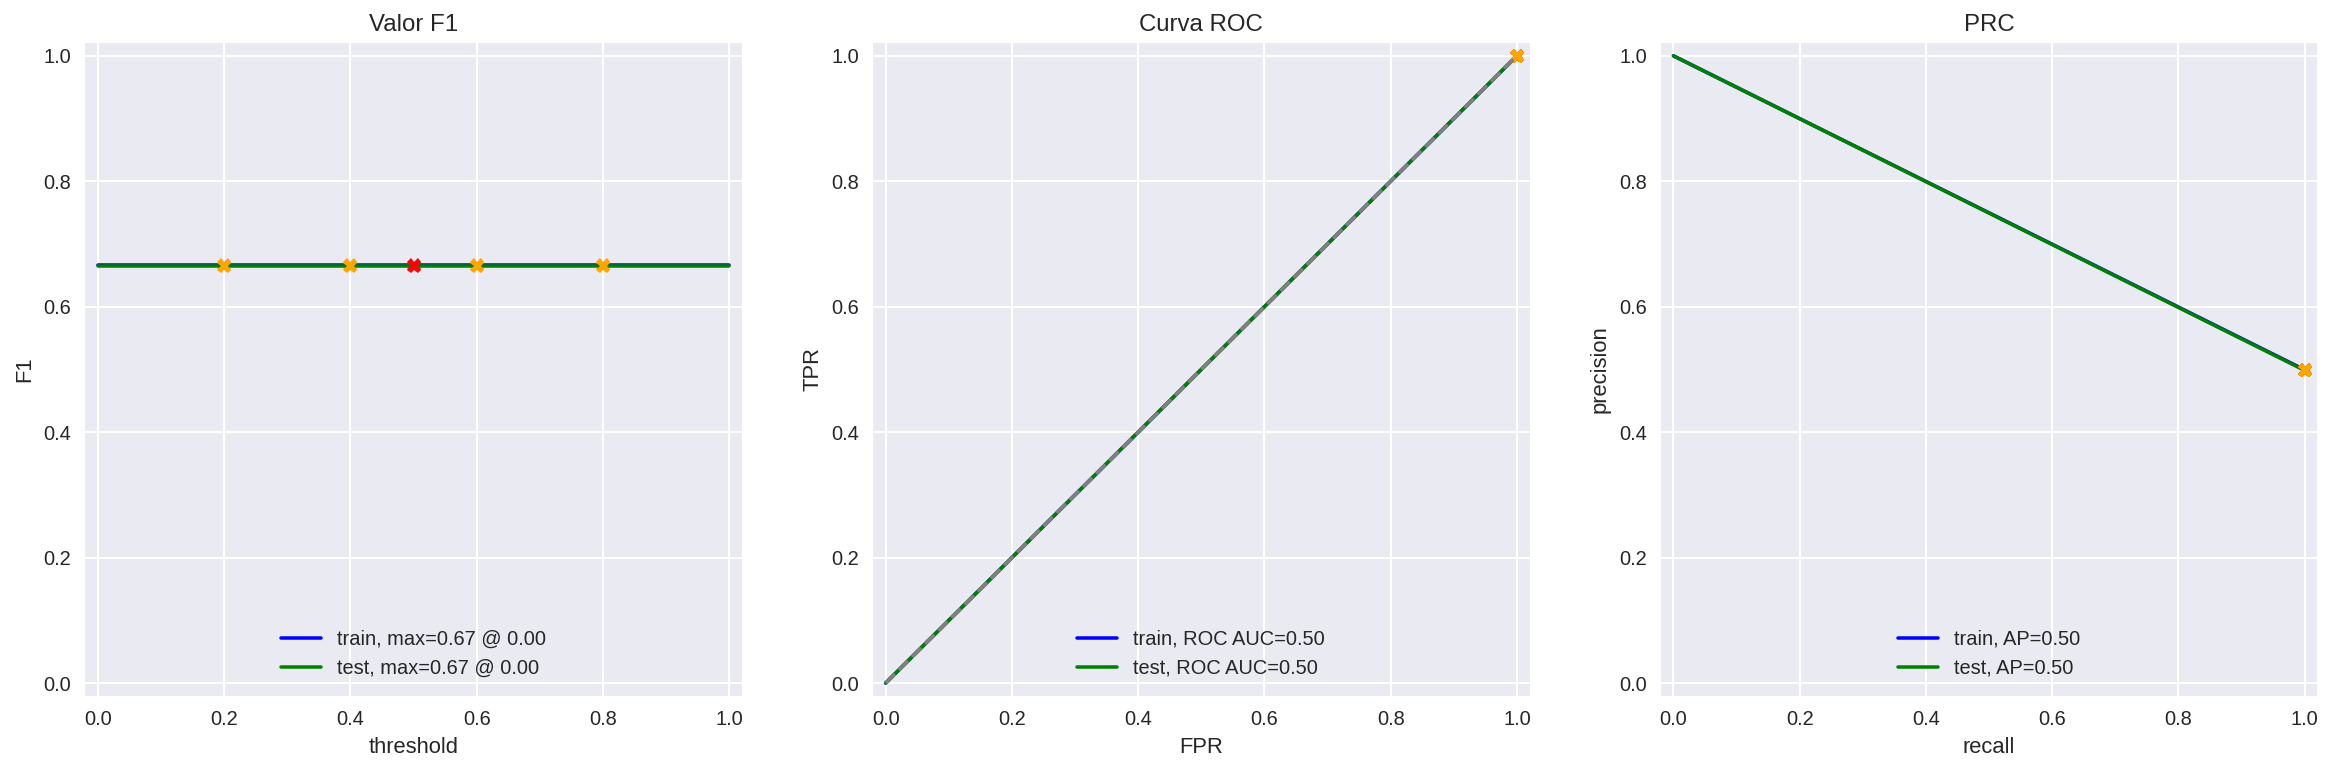

In [21]:
# entrenamos el modelo

dummy_clf = DummyClassifier(strategy = 'constant', constant = 1)

model_0 = dummy_clf.fit(X = df_reviews_train, y = train_target)

evaluate_model(model_0, np.empty(len(train_target)), train_target, np.empty(len(test_target)), test_target)

**Conclusiones intermedias:**
    
1. Se observa que el valor de F1 esta lejos del umbral esperado, con un 0.67

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [22]:
tfidf_vectorizer_2 = TfidfVectorizer(stop_words = stopwords.words('english'), lowercase = True)

In [23]:
train_features = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm'])
print(train_features.shape)

(23796, 71531)


In [24]:
test_features = tfidf_vectorizer_2.transform(df_reviews_test['review_norm'])
print(test_features.shape)

(23535, 71531)


In [25]:
model_2 = LogisticRegression()

model_2.fit(train_features, train_target)

LogisticRegression()

           train  test
Exactitud   0.94  0.88
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


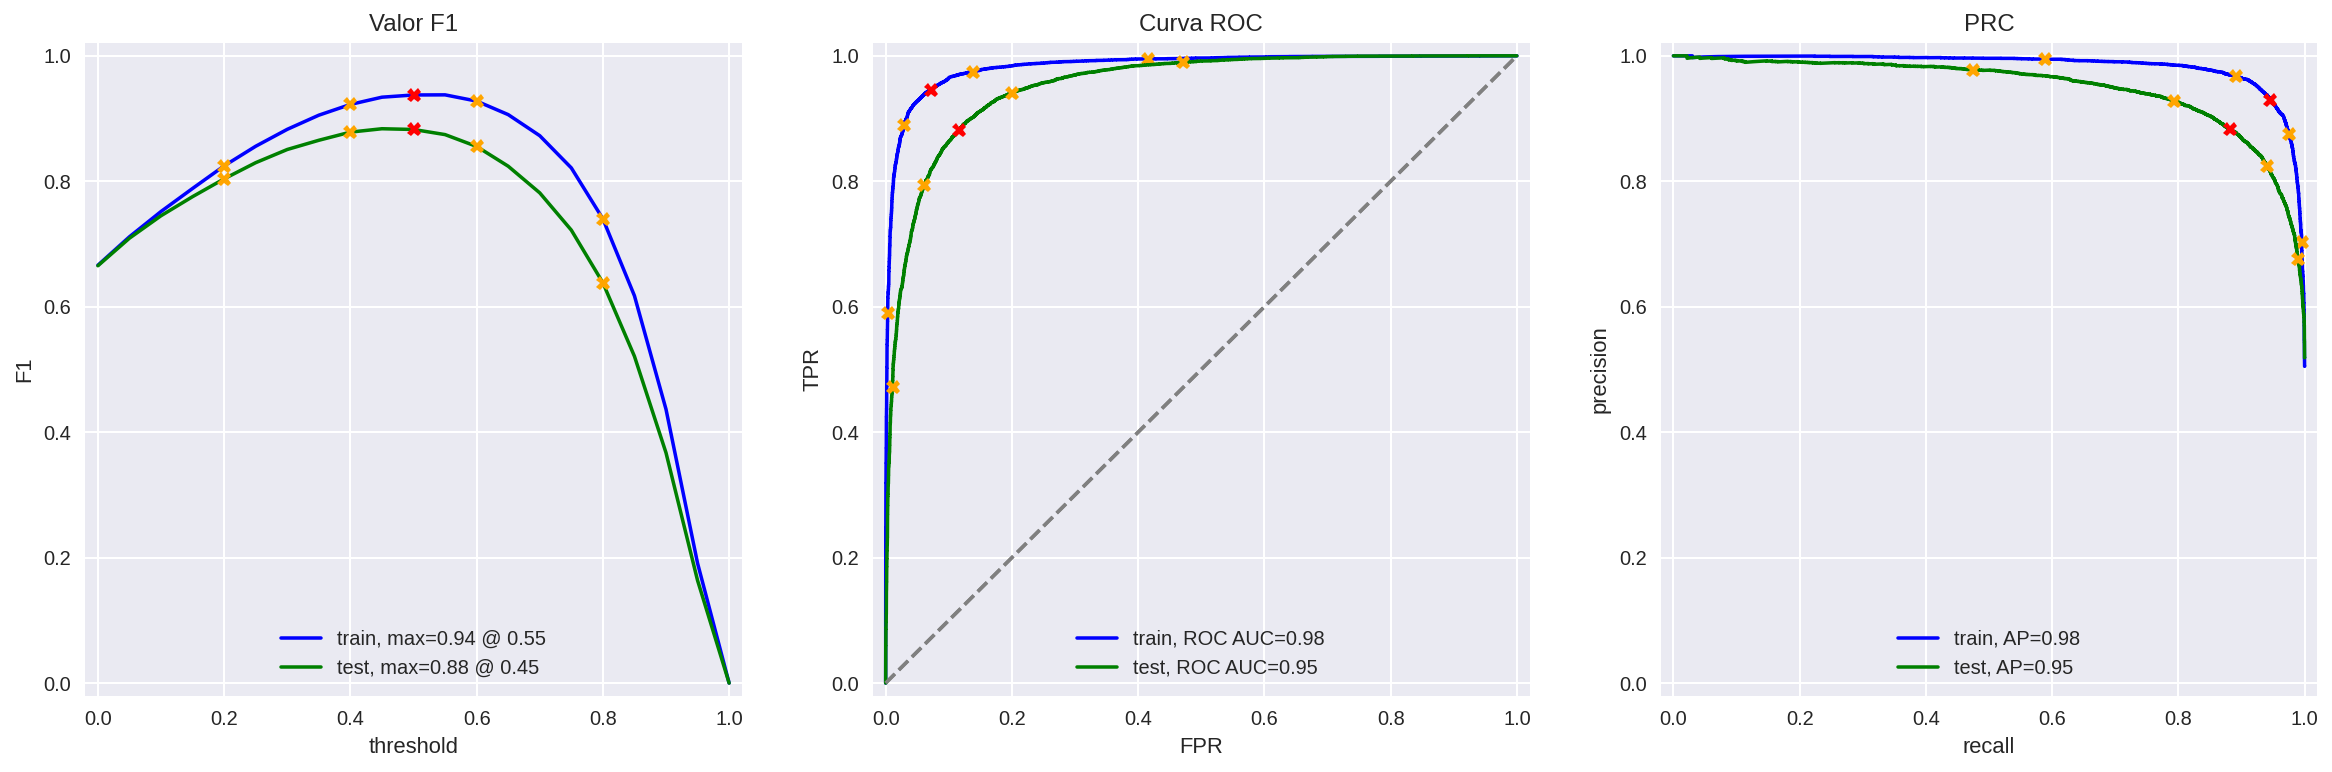

In [26]:
evaluate_model(model_2, train_features, train_target, test_features, test_target)

**Conclusiones intermedias:**
    
1. El valor de F1 es mejor que el valor anterior de Dummy Constante, pero supera el valor umbral, existiendo una diferencia entre ambos conjuntos de 0.94 y 0.88.
    


### Modelo 3 - spaCy, TF-IDF y LR

In [27]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [28]:
%%time

df_reviews_train['review_tokenized_3'] = df_reviews_train['review_norm'].progress_apply(lambda x: text_preprocessing_3(x))

  0%|          | 0/23796 [00:00<?, ?it/s]

CPU times: user 10min 48s, sys: 2.08 s, total: 10min 51s
Wall time: 11min 8s


In [29]:
%%time

df_reviews_test['review_tokenized_3'] = df_reviews_test['review_norm'].progress_apply(lambda x: text_preprocessing_3(x))

  0%|          | 0/23535 [00:00<?, ?it/s]

CPU times: user 10min 1s, sys: 2.26 s, total: 10min 3s
Wall time: 10min 19s


In [30]:
df_reviews_train['review_tokenized_3'].head()

0    the pakage imply that warren beatty and goldie...
1    how the hell do they get this make    present ...
7    this true story of carlson s raider be more of...
8    should have be title   balderdash    little in...
9    the movie   gung ho     the story of carlson s...
Name: review_tokenized_3, dtype: object

In [31]:
df_reviews_test['review_tokenized_3'].head()

2    there be no real story the film seem more like...
3    um       a serious film about troubled teen in...
4    I m totally agree with garryjohal from singapo...
5    this be the first movie I ve see from singapor...
6    yes non singaporean s can t see what s the big...
Name: review_tokenized_3, dtype: object

In [32]:
tfidf_vectorizer_3 = TfidfVectorizer()

In [33]:
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_tokenized_3'])
print(train_features_3.shape)

(23796, 59517)


In [34]:
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_tokenized_3'])
print(test_features_3.shape)

(23535, 59517)


In [35]:
model_3 = LogisticRegression()

model_3.fit(train_features_3, train_target)

LogisticRegression()

           train  test
Exactitud   0.93  0.88
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


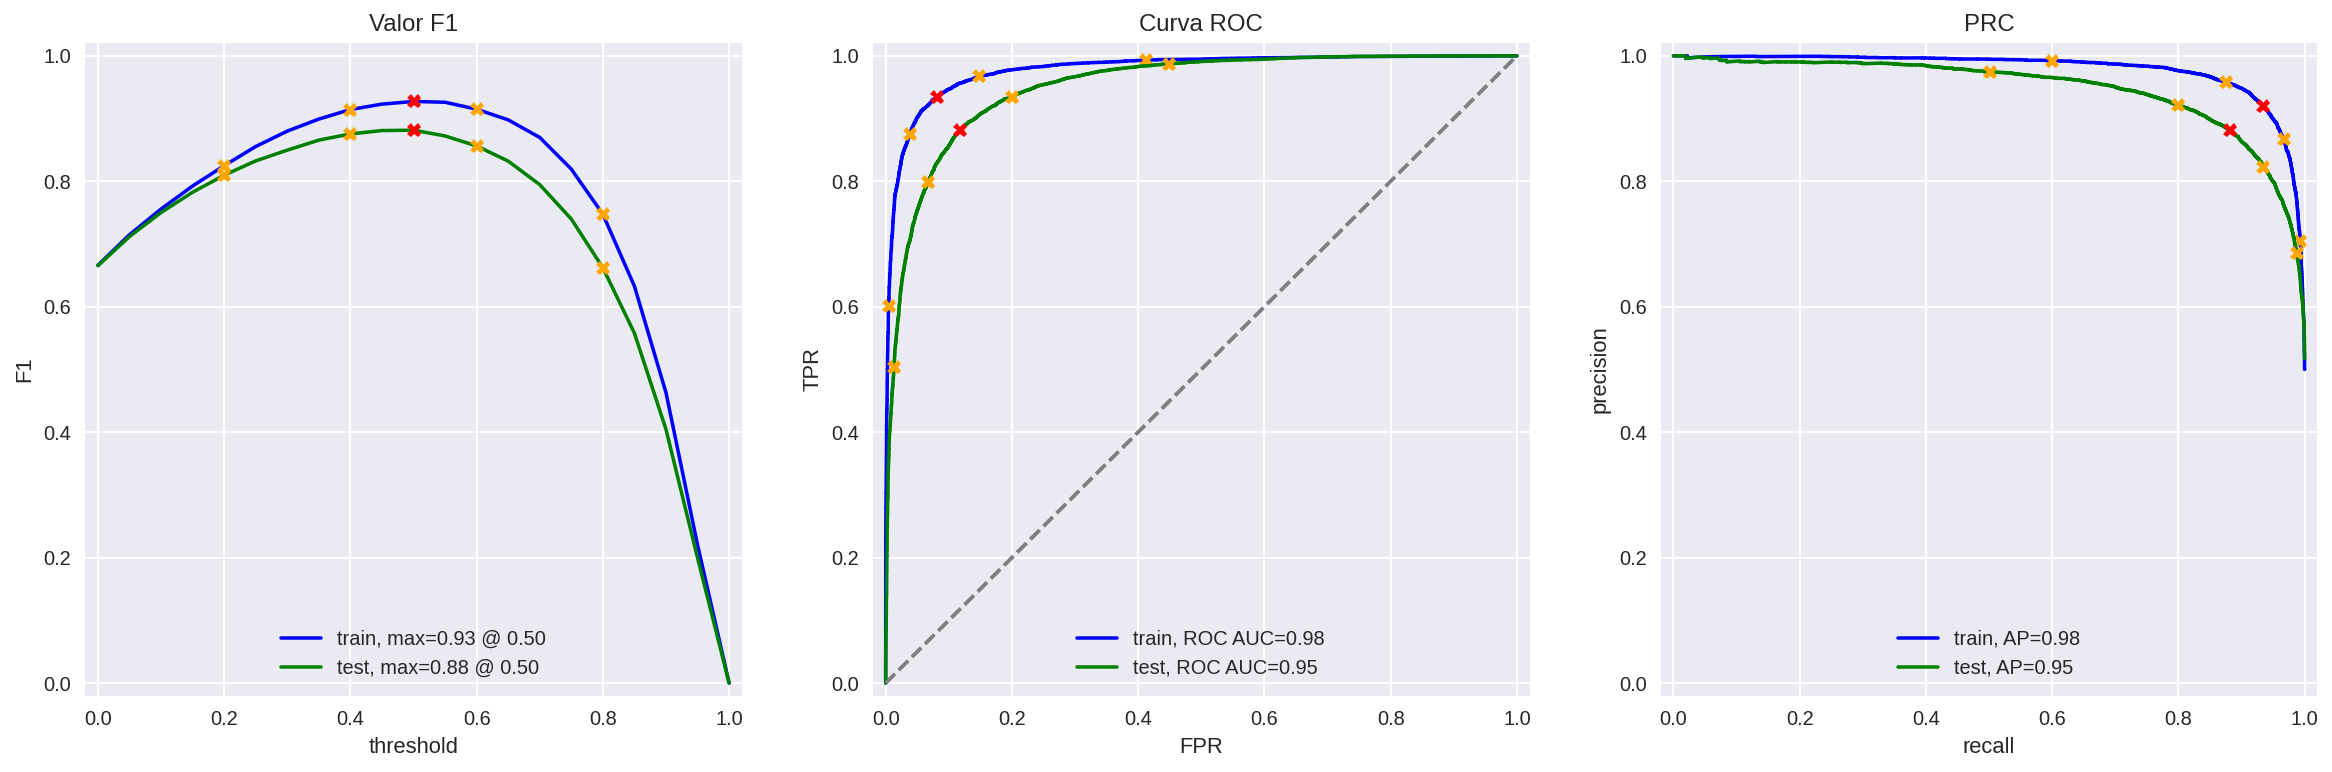

In [37]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

**Conclusiones intermedias:**
    
Este modelo reproduce resultados casi iguales que el modelo anterior, pero son ligeramente mejores, lo que nos lleva que por ahora es el mejor modelo a recomendar.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [38]:
%%time

model_4 = LGBMClassifier(learning_rate = .1)

model_4.fit(train_features_3, train_target)

CPU times: user 1min 12s, sys: 314 ms, total: 1min 12s
Wall time: 1min 12s


LGBMClassifier()

           train  test
Exactitud   0.92  0.86
F1          0.92  0.86
APS         0.98  0.93
ROC AUC     0.98  0.94


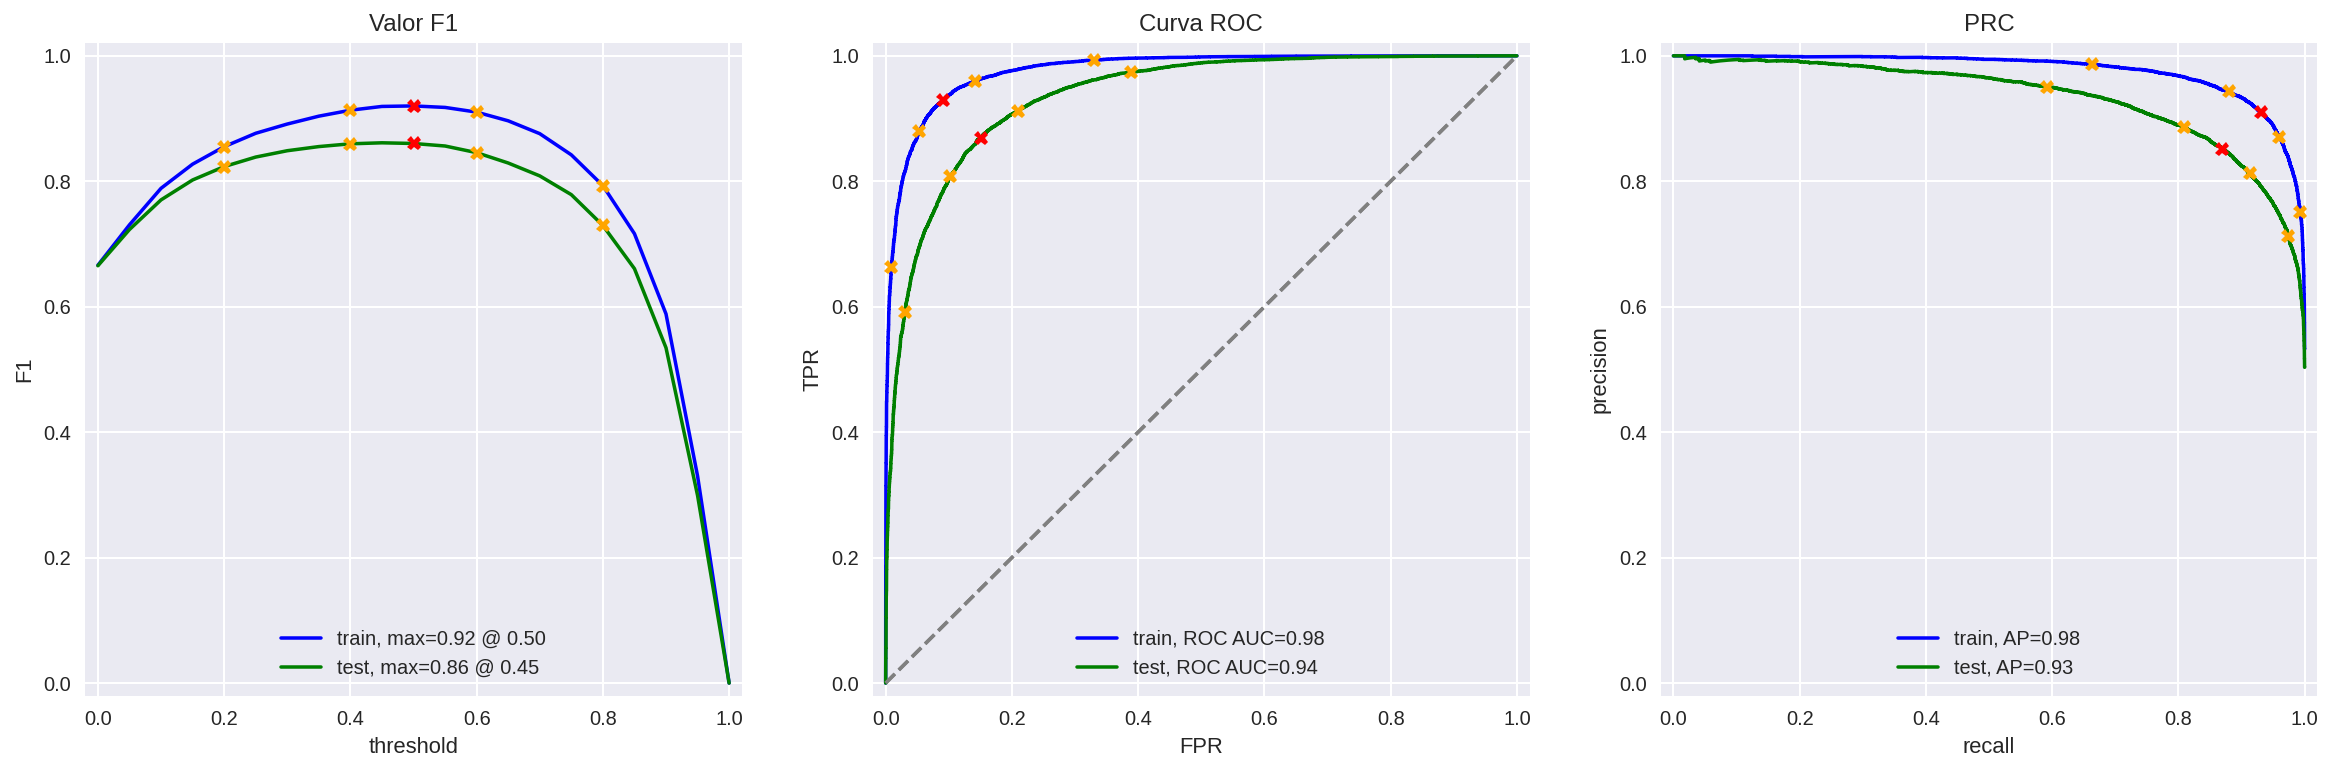

In [39]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

**Conclusiones intermedias:**

Al ver los resultados, no ofrece mejores resultados que el model de spaCy, TF-IDF y LR.

###  Modelo 9 - BERT

In [ ]:
#import torch
#import transformers

In [ ]:
#tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
#config = transformers.BertConfig.from_pretrained('bert-base-uncased')
#model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
#def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
#    ids_list = []
#    attention_mask_list = []

#    for input_text in tqdm(texts, disable = disable_progress_bar):
#        ids = tokenizer.encode(input_text.lower(), add_special_tokens = True, truncation = True, max_length=max_length)
#        padded = np.array(ids + [0]*(max_length - len(ids)))
#        attention_mask = np.where(padded != 0, 1, 0)
#        ids_list.append(padded)
#        attention_mask_list.append(attention_mask)
    
#    if force_device is not None:
#        device = torch.device(force_device)
#    else:
#        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#    model.to(device)
#    if not disable_progress_bar:
#        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
#    embeddings = []

#    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
#        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
#        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
#        with torch.no_grad():            
#            model.eval()
#            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
#        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
#    return np.concatenate(embeddings)

In [ ]:
#%%time

# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas


#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Mis reseñas

In [40]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middl...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i real...


### Modelo 2

In [41]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it  not my kind of movie 
0.16:  well  i was bored and felt asleep in the middle of the movie 
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.31:  i didn t expect the reboot to be so good  writers really cared about the source material
0.47:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.82:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi






### Modelo 3

In [42]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it  not my kind of movie 
0.22:  well  i was bored and felt asleep in the middle of the movie 
0.48:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.19:  i didn t expect the reboot to be so good  writers really cared about the source material
0.69:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.87:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Modelo 4

In [43]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.64:  i did not simply like it  not my kind of movie 
0.59:  well  i was bored and felt asleep in the middle of the movie 
0.58:  i was really fascinated with the movie
0.60:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.60:  i didn t expect the reboot to be so good  writers really cared about the source material
0.75:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.20:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.76:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Modelo 9

In [44]:
#texts = my_reviews['review_norm']

#my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

#my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

#for i, review in enumerate(texts.str.slice(0, 100)):
#    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusiones

1. Preparación de los datos

Nos encontramos con un DataFrame de 47331 filas y 17 columnas.
Se cargaron unas librerias para efectos de trabajar mejor.
Se mostro la información estadística y una muestra general del DataFrame.

2. EDA

Se pudo observar que en cada año aumenta las películas revisadas, se maneja la hipotesis que puede ser debido al incremento de usuarios o que las personas se les dificulta acceder a películas anteriores, sobre todo si no estan en formatos digitales actuales.

3. Modelo

Al aplicar varios modelos, obtuvimos lo siguiente:

a. El modelo de Regresion Logistica con NLTK y TF-IDF da valores mucho mejores que el modelo Dummy.
b. Con respecto a las utilizaciones del modelo de Regresión Logística, tenemos que con NLTK y TDF-IDF muestra casi la misma información que spaCy y TF-IDF, solo cambia la exactitud y el valor F1.
C. Cuando aplicamos el modelo LGBM con spaCy y TF_IDF, este nos da resultados que no son mejores que los de Regresion Logistica usando igual spaCy y TF-IDF.
d. El modelo Bert no se pudo aplicar por no contar con suficiente memoria GPU.

A manera de colofón, usando los modelos planteados, recomendamos el modelo de regresion logística usando NLTK y TF_IDF, es el que nos muestra mejores resultados en los campos de entrenamiento y prueba.



# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código 
- [ ]  Hay conclusiones 